$\Delta t = -g (dg/dt)^{-1}$ <br>
$g = \textbf{rs} \cdot d\textbf{rs}/dt$ <br>
$\Delta t = - g (\partial g/ \partial t)^{-1}$

In [17]:
import matplotlib.pyplot as plt
plt.style.use('./accretion.mplstyle')
import numpy as np
from astropy import constants as const
from astropy import units as u
from collections import OrderedDict
from itertools import cycle
import matplotlib.image as mpimg
import scipy.ndimage as ndimage
from scipy import interpolate
from scipy.stats import linregress as linfit
img = mpimg.imread('/storage/home/nxt5197/work/577_exoplanets/eye.png')

In [18]:
# Functions for integrator in 3D

def dvidt(M_j,r_ij,r_i,r_j):
    G = const.G.cgs
    dvdt=[0,0,0]
    dvdt[0] = -(G*M_j/r_ij**3*(r_i[0] - r_j[0])).to(u.cm/u.day**2)
    dvdt[1] = -(G*M_j/r_ij**3*(r_i[1] - r_j[1])).to(u.cm/u.day**2)
    dvdt[2] = -(G*M_j/r_ij**3*(r_i[2] - r_j[2])).to(u.cm/u.day**2)
    return dvdt

def rmag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(y_i-y_j)**2+(z_i-z_j)**2)
    return r_ij

def r_s_mag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    z_i=r_i[2]
    x_j=r_j[0]
    y_j=r_j[1]
    z_j=r_j[2]
    r_ij = np.sqrt((x_i-x_j)**2+(z_i-z_j)**2)
    return r_ij

def get_r_final(r,v,dt):
    x,y,z = r+v*dt
    return x,y,z

In [19]:
line_options=[(0,()), # solid 
                     (0, (1, 10)), # loosely dotted
                     (0, (1, 5)), # dotted
                     (0, (1, 1)), # densely dotted
                     (0, (5, 10)), # loosely dashed
                     (0, (5, 5)), # dashed
                     (0, (5, 1)), # densely dashed
                     (0, (3, 10, 1, 10)), # loosely dashdotted
                     (0, (3, 5, 1, 5)), # dashdotted
                     (0, (3, 1, 1, 1)), # densely dashdotted
                     (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                     (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                     (0, (3, 1, 1, 1, 1, 1))]

In [20]:
b = OrderedDict((("Sun",0),("Venus",1),("Earth",2)))

linecycler = cycle(line_options[:len(b)])

G = const.G.cgs
m_sun = const.M_sun.to(u.g)
m_v = (4.8673*10**27)*u.g
m_e = const.M_earth.to(u.g)
m = OrderedDict(((0,m_sun),(1,m_v),(2,m_e)))

a_v = 0.723*const.au.to(u.cm)
a_e = const.au.to(u.cm)
a = OrderedDict(((1,a_v),(2,a_e)))
a_sun = -sum([m[i]*a[i] for i in a])/m_sun
a = OrderedDict(((0,a_sun),(1,a_v),(2,a_e)))

v_sun = -(0.13*u.m/u.s).to(u.cm/u.day)
v_v = 1.18*(29.78*u.km/u.s).to(u.cm/u.day)
v_e = (29.78*u.km/u.s).to(u.cm/u.day)
vstart = OrderedDict(((0,v_sun),(1,v_v),(2,v_e)))

colors = OrderedDict(((0,'white'),(1,'yellow'),(2,'blue')))
period = OrderedDict(((0,0),(1,0.615),(2,1)))

In [21]:
# Set timesteps and number of orbits here

delta_t = 1*u.day

orbits = 50

t_range = np.arange(0,orbits*365,delta_t.value)*u.day      # 1 year timescale in steps of delta_t

In [22]:
# Skip = ['Venus']
Skip = []

In [23]:
# Initialize empty position, velocity, and acceleration arrays
Dimensions=3
r = [[[0,0,0]*u.cm for i in range(len(t_range))] for i in range(len(b))]
x = [[0]*len(t_range) for i in range(len(b))]
y = [[0]*len(t_range) for i in range(len(b))]
z = [[0]*len(t_range) for i in range(len(b))]
v = [[[0,0,0]*u.cm/u.day for i in range(len(t_range))] for i in range(len(b))]
dvdt = [[[0,0,0]*u.cm/u.day**2 for i in range(len(t_range))] for i in range(len(b))]

# Set initial position for each body
for i,bdy in enumerate(b):
    r[i][0][0] = a[i]
    r[i][0][1] = 0*u.cm
    r[i][0][2] = 0*u.cm
    x[i][0] = r[i][0][0]
    y[i][0] = r[i][0][1]
    z[i][0] = r[i][0][2]
    v[i][0][0] = 0*u.cm/u.day
    v[i][0][1] = vstart[i]
    v[i][0][2] = 0*u.cm/u.day

In [24]:
# Integrate over all timesteps to get orbital parameters for each body

steps=len(t_range) # The number of steps in the time array
    
for t in range(steps-1): # indexing each timestep as t
    # Update the next position for each body
    for i, body in enumerate(b):
        r[i][t+1][0], r[i][t+1][1], r[i][t+1][2] = get_r_final(r[i][t],v[i][t],delta_t)
        x[i][t+1], y[i][t+1], z[i][t+1] = get_r_final(r[i][t],v[i][t],delta_t)

    # Update the next velocity for each body
    for i, body in enumerate(b):
        if body in Skip:
            continue
        # Sum effects of all bodies j on each body i in the system
        for j, body in enumerate(b):
            if body in Skip:
                continue
            if i==j:
                continue
            r_ij = rmag(r[i][t+1],r[j][t+1])
            dvdt[i][t][0] += dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])[0]
            dvdt[i][t][1] += dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])[1]
            dvdt[i][t][2] += dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])[2]

        v[i][t+1][0] = v[i][t][0] + dvdt[i][t][0] * delta_t
        v[i][t+1][1] = v[i][t][1] + dvdt[i][t][1] * delta_t
        v[i][t+1][2] = v[i][t][2] + dvdt[i][t][2] * delta_t 

In [25]:
# Set global functions based on calculated orbital parameter arrays
xfunc=[0 for i in b]
yfunc=[0 for i in b]
zfunc=[0 for i in b]
vfunc=[[0,0,0] for i in b]
afunc=[[0,0,0] for i in b]
for i,body in enumerate(b):
    xfunc[i] = interpolate.interp1d([t.value for t in t_range],[k.value for k in x[i]])
    yfunc[i] = interpolate.interp1d([t.value for t in t_range],[k.value for k in y[i]])
    zfunc[i] = interpolate.interp1d([t.value for t in t_range],[k.value for k in z[i]])
    for D in range(Dimensions):
        vfunc[i][D] = interpolate.interp1d([t.value for t in t_range],[k[D].value for k in v[i]])
        afunc[i][D] = interpolate.interp1d([t.value for t in t_range],[k[D].value for k in dvdt[i]])

# FUNCTIONS BELOW ARE TEMPORARILY IN 2D ONLY
def g(transitting_body,t):
    i = transitting_body
    return (xfunc[i](t)-xfunc[0](t))*(vfunc[i][0](t)-vfunc[0][0](t))

def dgdt(transitting_body,t):
    i = transitting_body
    return (vfunc[i][0](t)-vfunc[0][0](t))**2+(xfunc[i](t)-xfunc[0](t))*(afunc[i][0](t)-afunc[0][0](t))

def get_approx_transits(transitting_body,t_array,num_orbits):
    i = transitting_body
    trange=[int(t.value) for t in t_array]
    approx_transits = [0 for k in range(num_orbits)]
    orbit=0
    for t in trange:
        if yfunc[i](t)>0 and t>trange[0] and t<trange[-1]:
            if abs(xfunc[i](t)-xfunc[0](t)) < abs(xfunc[i](t-1)-xfunc[0](t-1)) and abs(xfunc[i](t)-xfunc[0](t)) < abs(xfunc[i](t+1)-xfunc[0](t+1)):
                approx_transits[orbit] = t
                orbit+=1
    return approx_transits

def pinpoint_transits(transitting_body,approx_transits):
    count=0
    while max(g(transitting_body,approx_transits)) > 10**-15:
        g_array = g(transitting_body,approx_transits)
        dgdt_array = dgdt(transitting_body,approx_transits)
        approx_transits += - g_array / dgdt_array
        count += 1
        if count == 10:
            print(f'You fucked up. Count: {count}.\nBreaking While Loop Manually.')
            break
    return approx_transits

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


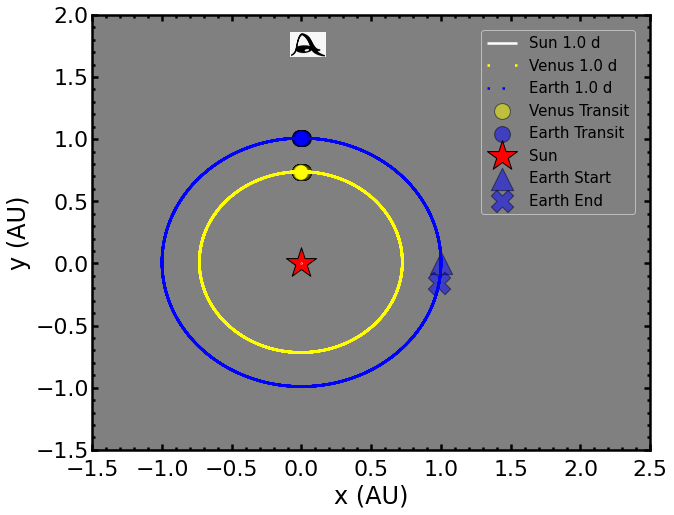

In [26]:
# Plot the orbits and the approximate transits for the planets over the given number of earth orbits.
plt.rcParams.update({"axes.facecolor":"gray"})
fig=plt.figure(figsize=(10,8))
transitss=[[0]]
for i, body in enumerate(b):
    if body in Skip:
        continue
    x_au = [(xs/a[b["Earth"]]).value for xs in x[i]]
    y_au = [(ys/a[b["Earth"]]).value for ys in y[i]]
    z_au = [(zs/a[b["Earth"]]).value for zs in z[i]]
    line=next(linecycler)
    plt.plot(x_au,y_au,linestyle=line,color=colors[i],label=f'{list(b.items())[i][0]} {delta_t}')
    if i>0:
        num_orbits=int(orbits/period[i])
        transits=get_approx_transits(i,t_range,num_orbits)
        label_added=False
        if tuple(transits):
            for w in transits:
                if not label_added:
                    plt.scatter(x_au[w],y_au[w],marker="o",s=250,color=colors[i], edgecolors='black',label=f'{list(b.items())[i][0]} Transit',alpha=0.5)
                    label_added = True
                else:
                    plt.scatter(x_au[w],y_au[w],marker="o",s=250,color=colors[i], edgecolors='black',alpha=0.5)
        transitss.append(transits)
plt.scatter(x[b["Sun"]][0]/a_e,y[b["Sun"]][0]/a_e,marker="*",s=1000,color='red', edgecolors='black',label=f'Sun')
for i, body in enumerate(b):
    if body in Skip or i == 0:
        continue
plt.scatter(x[i][0]/a_e,y[i][0]/a_e,marker="^",s=500,color=colors[i], edgecolors='black',alpha=0.5,label=f'{list(b.items())[i][0]} Start')
plt.scatter(x[i][-1]/a_e,y[i][-1]/a_e,marker="X",s=500,color=colors[i], edgecolors='black',alpha=0.5,label=f'{list(b.items())[i][0]} End')
plt.ylabel('y (AU)')
plt.xlabel('x (AU)')
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2)
plt.legend(prop={'size': 15})
new_img = ndimage.rotate(img, -90, reshape=True)
newax = fig.add_axes([0.4, 0.8, 0.05, 0.05], anchor='NE', zorder=1)
newax.imshow(new_img)
newax.axis('off')
plt.show()

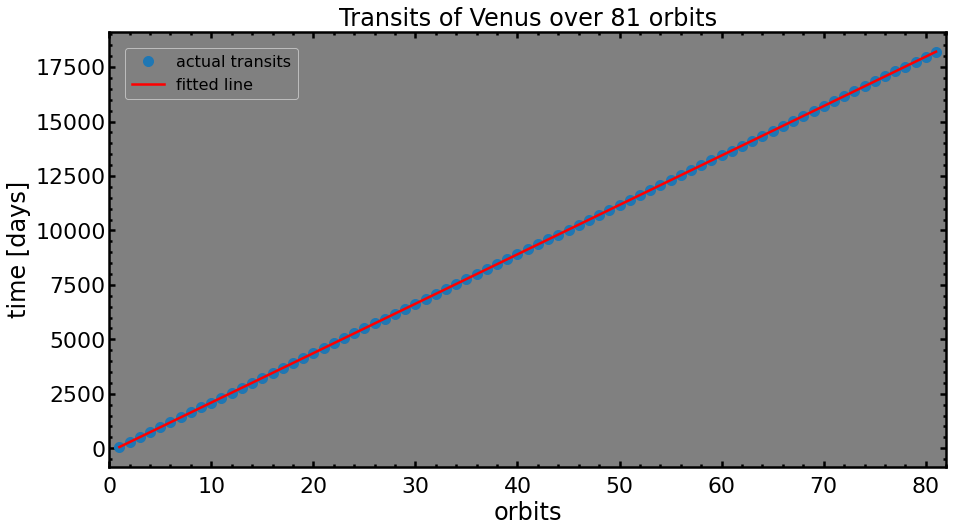

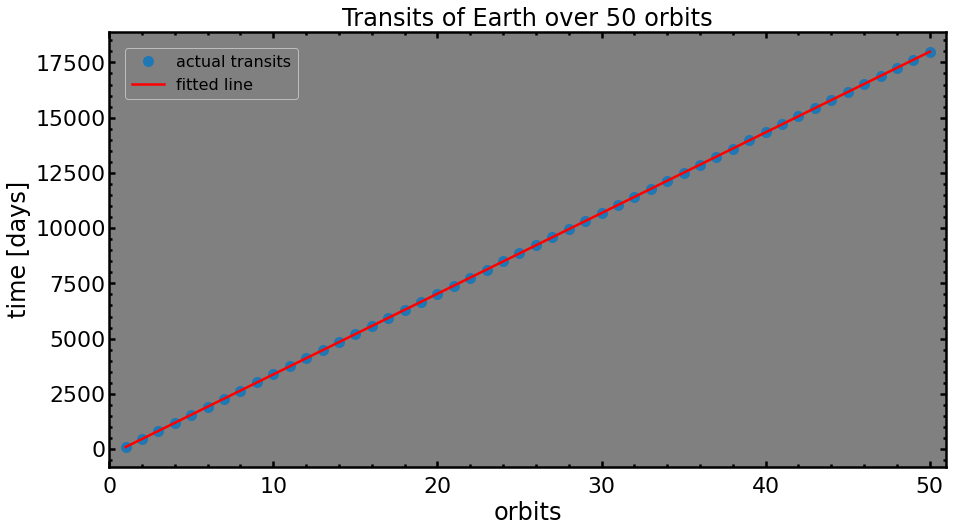

In [27]:
regs = [0 for k in range(len(b))]
for i in range(1,len(b)):
    if list(b.items())[i][0] in Skip:
        continue
    num_orbits=int(orbits/period[i])
    approx_transits = get_approx_transits(i,t_range,num_orbits)
    real_transits=pinpoint_transits(i,approx_transits)
    orbit_range=range(1,len(real_transits)+1)
    # real_transits = [t.value for i,t in enumerate(transitss[2])]
    regs[i] = linfit(orbit_range,real_transits)
    reg = regs[i]
    plt.plot(orbit_range, real_transits, 'o', label='actual transits')
    plt.plot(orbit_range, reg.intercept + reg.slope*orbit_range, 'r', label='fitted line')
    plt.ylabel(r'time [days]')
    plt.xlabel(r'orbits')
    plt.xlim(0,num_orbits+1)
    plt.title(f'Transits of {list(b.items())[i][0]} over {num_orbits} orbits')
    plt.legend()
    plt.show()

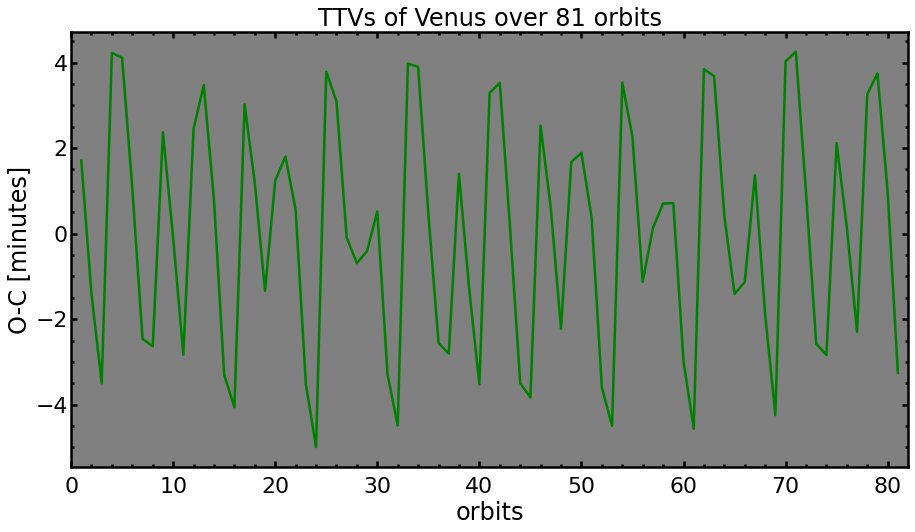

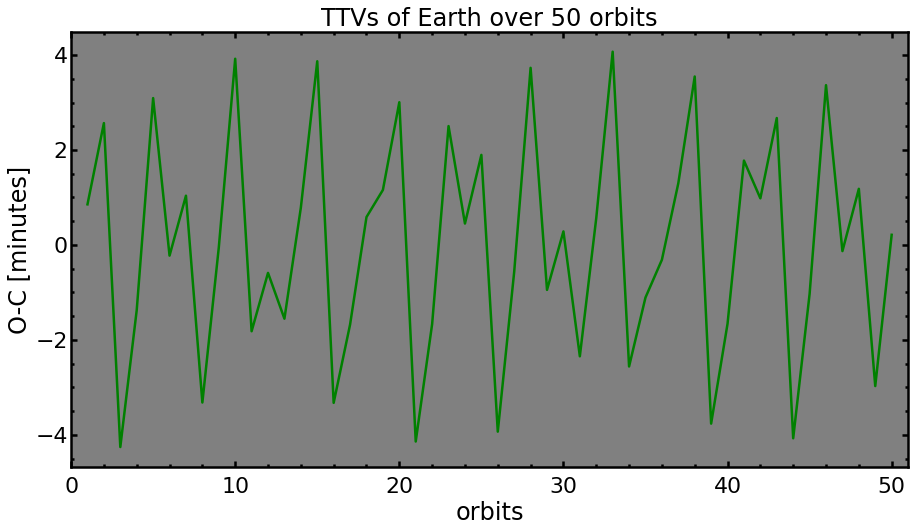

In [28]:
for i in range(1,len(b)):
    if list(b.items())[i][0] in Skip:
        continue
    num_orbits=int(orbits/period[i])
    approx_transits = get_approx_transits(i,t_range,num_orbits)
    real_transits=pinpoint_transits(i,approx_transits)
    orbit_range=range(1,len(real_transits)+1)
    reg = regs[i]
    plt.plot(orbit_range, (real_transits-(reg.intercept + reg.slope*orbit_range))*24*60, 'g')
    plt.ylabel(r'O-C [minutes]')
    plt.xlabel(r'orbits')
    plt.xlim(0,num_orbits+1)
    plt.title(f'TTVs of {list(b.items())[i][0]} over {num_orbits} orbits')
    plt.show()

In [29]:
# for i in range(1,len(b)):
#     if list(b.items())[i][0] in Skip:
#         continue
#     num_orbits=int(orbits/period[i])
#     approx_transits = get_approx_transits(i,t_range,num_orbits)
#     real_transits=pinpoint_transits(i,approx_transits)
#     orbit_range=range(1,len(real_transits)+1)
#     plt.plot(real_transits,g(i,real_transits)/1e19)
#     plt.ylabel(r'g(t) $\times 10^{19}$')
#     plt.xlabel(r'transit times [days]')
#     plt.xlim(0,max(real_transits))
#     plt.title(f'g(approximate transit time) of {list(b.items())[i][0]} over {num_orbits} orbits')
#     plt.show()

In [30]:
# t=[t.value for t in t_range]
# for i in range(1,len(b)):
#     if list(b.items())[i][0] in Skip:
#         continue
#     num_orbits=int(orbits/period[i])
#     plt.plot(t,g(i,t)/1e24)
#     plt.ylabel(r'g(t) $\times 10^{24}$')
#     plt.xlabel(r't [days]')
#     plt.xlim(0,max(t))
#     plt.title(f'g(all times) of {list(b.items())[i][0]} over {num_orbits} orbits')
#     plt.show()